In [401]:
import os
import shutil
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

import numpy as np

import ase
from ase import Atoms, io
from ase.data import covalent_radii
from ase.io.pov import get_bondpairs, set_high_bondorder_pairs
from ase.visualize.plot import plot_atoms


from sklearn.decomposition import PCA

default_color_dict = {
    "Cl": [102, 227, 115],
    "C": [61, 61, 64],
    "O": [240, 10, 10],
    "N": [10, 10, 240],
    "F": [0, 232, 0],
    "H": [232, 206, 202],
    "K": [128, 50, 100],
    "X": [200, 200, 200],
}



def render_povray(
    atoms, pov_name, rotation="0x, 0y, 0z", radius_scale=0.25, color_dict=None,
    vectors = None, angles = None, planes = None,
):

    # align the molecule to the principal axes
    pca = PCA(n_components=3)
    pca.fit(atoms.get_positions())
    atoms.set_positions(pca.transform(atoms.get_positions()))

    if color_dict is None:
        color_dict = default_color_dict

    path = Path(pov_name)
    pov_name = path.name
    base = path.parent

    radius_list = []
    for atomic_number in atoms.get_atomic_numbers():
        radius_list.append(radius_scale * covalent_radii[atomic_number])

    colors = np.array([color_dict[atom.symbol] for atom in atoms]) / 255

    bondpairs = get_bondpairs(atoms, radius=0.9)
    good_bonds = []
    good_bond_keys = []
    for _ in bondpairs:
        #  remove the Cl-Cl bonds
        if not (atoms[_[0]].symbol == "Cl" and atoms[_[1]].symbol == "Cl"):
            good_bonds.append(_)
            good_bond_keys.append((_[0], _[1]))
            good_bond_keys.append((_[1], _[0]))

    # create hydrogen bonds
    _pos = atoms.get_positions()
    _z = atoms.get_atomic_numbers()
    idx_onh = (_z == 8) | (_z == 1) | (_z == 7)
    idxs = np.where(idx_onh)[0]

    # create a mapping between atom idxs in the first atoms object
    # and the idxs in the new atoms object
    map = {}
    for i, idx in enumerate(idxs):
        map[i] = idx
    # create a new atoms object with only N, O and H atoms
    atoms_onh = Atoms(_z[idxs], _pos[idxs])
    bondpairs_onh = get_bondpairs(atoms_onh, radius=1.5)
    for _ in bondpairs_onh:
        if (map[_[0]], map[_[1]]) not in good_bond_keys:
            distance = np.linalg.norm(_pos[_[0]] - _pos[_[1]])
            # check that atom1 is H or N/O and atom2 is N/O or H
            if (_z[_[0]] == 1 and (_z[_[1]] == 7 or _z[_[1]] == 8)) or (
                _z[_[1]] == 1 and (_z[_[0]] == 7 or _z[_[0]] == 8)
            ):
                if 1.0 < distance < 3.5:
                    print(f"Adding bond between", map[_[0]], map[_[1]])
                    good_bonds.append(_)

    good_bonds = set_high_bondorder_pairs(good_bonds)

    kwargs = {  # For povray files only
        "transparent": True,  # Transparent background
        "canvas_width": 1028*2,  # Width of canvas in pixels
        "canvas_height": None,  # None,  # Height of canvas in pixels
        "camera_dist": 10,  # Distance from camera to front atom,
        "camera_type": "orthographic angle 0",  # 'perspective angle 20'
        "depth_cueing": False,
        "colors": colors,
        "bondatoms": good_bonds,
        "textures": ["jmol"] * len(atoms),
        'image_plane'  : None,
    }

    generic_projection_settings = {
        "rotation": rotation,
        "radii": radius_list,
    }

    povobj = io.write(
        pov_name, atoms, **generic_projection_settings, povray_settings=kwargs
    )


    from ase.io.utils import PlottingVariables
    pvars = PlottingVariables(ase_atoms, scale=1,
                              **generic_projection_settings)
    R = pvars.positions
    w = pvars.w
    h = pvars.h
    z0 = R[:, 2].max()
    shift = (w /2 , h /2 , z0)
    
    R = pvars.positions[:len(atoms)] - shift
    

    
    def center_normal(plane):
        plane = np.array(plane)
        center = plane.T.mean(axis=1)
        return center, np.linalg.norm(plane.T, axis=1)


    with open("render_povray.pov") as f:
        lines = f.readlines()
        
    with open(pov_name, "a") as f:
        for l in lines:
            f.write(l)
        
        def format_vec(array):
            """Povray array syntax"""
            return '<' + ', '.join(f"{x:>6.2f}" for x in tuple(array)) + '>'
                    
        if angles:

            angles = [[R[_[0]], R[_[1]], R[_[2]]] for _ in angles]
            for a in angles:
                dist = np.sum((a[2] - a[0])**2)**0.5
                print(dist)
                a = [format_vec(_) for _ in a]
                f.write(f"\nAngleMarker({a[0]}, {a[1]}, {a[2]}, {dist})\n")
    
        if planes:
            planes = [[R[_[0]], R[_[1]], R[_[2]]] for _ in planes]
            for p in planes:
                p = center_normal(p)
                p = [format_vec(_) for _ in p]
                f.write(f"\nPlane({p[0]}, {p[1]}, 0.1, 0.01)\n")
    
        if vectors:
            vectors = [[R[_[0]], R[_[1] ]] for _ in vectors]

            for v in vectors:
                v = [format_vec(_) for _ in v]
                f.write(f"\nArrow({v[0]}, {v[1]}, 0.02, 0.01)\n")


    
    povobj.render(
        povray_executable="/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/bin/povray"
    )
    png_name = pov_name.replace(".pov", ".png")
    shutil.move(png_name, base / png_name)
    
    return png_name, povobj


dpi = 300
import matplotlib as mpl
mpl.rcParams['figure.dpi']= dpi

In [402]:
ase_atoms = ase.io.read("../ghost-atoms/opt.xyz")


radius_list = []
for atomic_number in ase_atoms.get_atomic_numbers():
    radius_list.append( 0.25 * covalent_radii[atomic_number])

generic_projection_settings = {
    "rotation": "0x, 0y, 0z",
    "radii": radius_list,
}



In [403]:
from ase.io.pov import POVRAY



In [404]:
import itertools
R = list(range(len(ase_atoms)))
vectors = list(itertools.combinations(R, 2))
angles = list(itertools.combinations(R, 3))
planes = None #list(itertools.combinations(R, 3))


In [405]:
len(angles)
unique_a = []
for _ in angles:
    if sum(_) not in [sum(x) for x in unique_a]:
        unique_a.append(_)
    

In [406]:
unique_a

[(0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 2, 5),
 (0, 3, 5),
 (0, 4, 5),
 (1, 4, 5),
 (2, 4, 5),
 (3, 4, 5)]

Adding bond between 0 1
Adding bond between 0 2
Adding bond between 3 4
Adding bond between 3 5
6.995929746675325


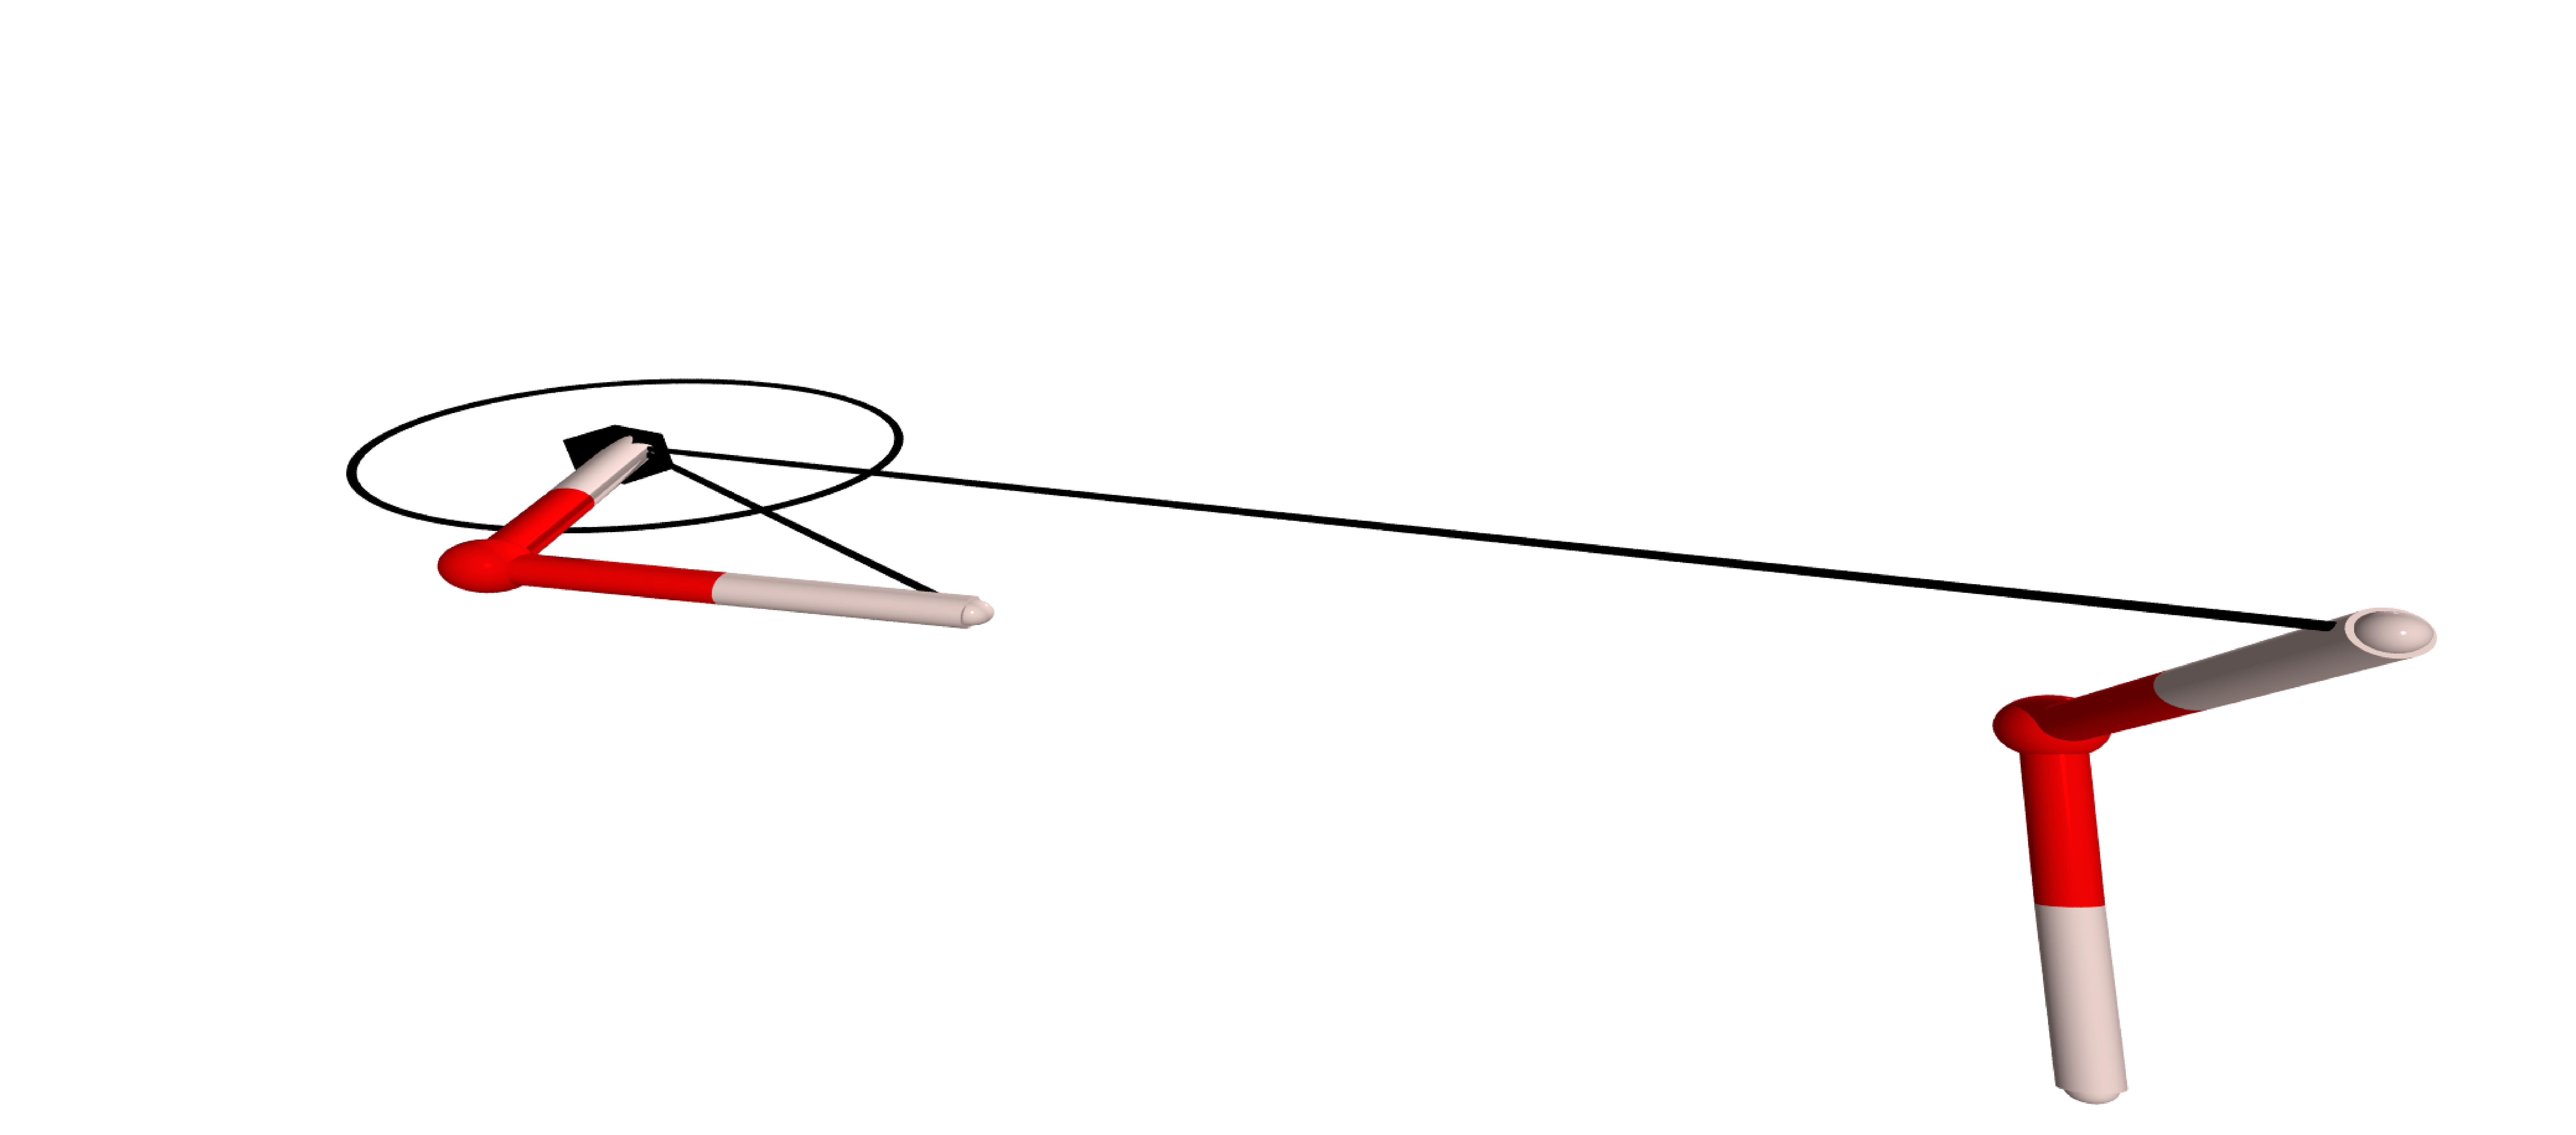

In [407]:
povfn = "render.pov"
assert povfn.endswith(".pov")
pngfn = povfn[:-4] + ".png"
fn, povo = render_povray(ase_atoms, povfn,
                         vectors = [[1,2], [4,1]], 
              angles = [[1,2,4]], 
              planes = planes,)

assert os.path.exists(pngfn)
ax = plt.gca()
ax.axis("off")
image = plt.imread(pngfn)
offset_image = OffsetImage(image, zoom=1)
annotation = AnnotationBbox(
    offset_image,
    (0, 1),
    frameon=False,
    boxcoords=ax.transAxes,
    zorder=10,  # Relative to the axes of the plot
)
ax.add_artist(annotation)